# Predicting the number of pit stops

The number of pit stops and their duration have decreased with the years? In the first phase of this subproject I'll try to predict how many stops will there be in the race and later I would like to predict when would them happen.

Bur first, some EDA...

In [192]:
from IPython.display import Image 
from IPython.core.display import HTML 
Image(url= "https://media.giphy.com/media/MovqJSMROh1gA/giphy.gif") 

## EDA

### Setting up the main dataset

In [193]:
#The data stored in this path is obtained from the API of https://ergast.com/mrd/. It is continuously updated.
#To update this data please run the file "API_Requests_Results_Qualifying_Laps_PitStops.py"

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer #set scores desired to train models
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score #measures used to evaluate the models


path = 'C:/Users/gabri/Dropbox/Gaby/Proyectos/My_Portafolio/F1/Data/'

PitsDF=pd.read_csv(path+"PitsDF.csv")

selectednumber=19440102 #randomseed

We should import info from the results data so that we can know the result of each driver at the end of each race. We should only take into account the drivers that ended each race. If the driver do not ends the race, they will probably have no pit stops.

In [194]:
ResultsDF=pd.read_csv(path+"ResultsDF.csv")
PitsDF=PitsDF.drop(columns=['Unnamed: 0'])

In [195]:
#Transforming pits duration into seconds:
PitsDF[['durationSEC','nothing']]=PitsDF['duration'].str.split(":", expand=True)
PitsDF['duration_in_sec']=PitsDF['durationSEC'].astype(float)
PitsDF=PitsDF.drop(columns=['durationSEC','nothing'])


In [196]:
#Creating Season-Round feature:
ResultsDF["Season-Round-Driver"]=ResultsDF["season"].astype(str)+"-"+ResultsDF["round"].astype(str)+"-"+ResultsDF["Driver.driverId"].astype(str)
PitsDF["Season-Round-Driver"]=PitsDF["season"].astype(str)+"-"+PitsDF["round"].astype(str)+"-"+PitsDF["driverId"].astype(str)

In [197]:
#Left Join of the Pits DF with the Results DF
PitsExtraDF=PitsDF.merge(ResultsDF[["Season-Round-Driver","status",'Constructor.constructorId','Constructor.name',"laps"]],on="Season-Round-Driver",how="left")

In [198]:
#Top number of pits per race:
PitsExtraDF["stop"].unique()

array([1, 2, 3, 4], dtype=int64)

In [199]:
#Dividing the main df into separate ones taking into account the number of stops, to then unify them:
Pits1ExtraDF = PitsExtraDF[PitsExtraDF["stop"]==1].rename(columns={'lap': 'Pit1_lap',"time":"Pit1_time","duration_in_sec":"Pit1_duration"})
Pits2ExtraDF = PitsExtraDF[PitsExtraDF["stop"]==2].rename(columns={'lap': 'Pit2_lap',"time":"Pit2_time","duration_in_sec":"Pit2_duration"})
Pits3ExtraDF = PitsExtraDF[PitsExtraDF["stop"]==3].rename(columns={'lap': 'Pit3_lap',"time":"Pit3_time","duration_in_sec":"Pit3_duration"})
Pits4ExtraDF = PitsExtraDF[PitsExtraDF["stop"]==4].rename(columns={'lap': 'Pit4_lap',"time":"Pit4_time","duration_in_sec":"Pit4_duration"})

PitsUnified=Pits1ExtraDF[['Season-Round-Driver', 'date', 'status', 'driverId', 'season','round', 'raceName', 'Circuit.circuitId', 'Circuit.circuitName',
       'Circuit.Location.country','Constructor.constructorId', 'Constructor.name', 'laps',
       'Pit1_lap', 'Pit1_time', 'Pit1_duration']]

#Unifying the separate datasets forming one dataset with one row per race and per driver
PitsUnified=PitsUnified.merge(Pits2ExtraDF[["Season-Round-Driver",'Pit2_lap', 'Pit2_time', 'Pit2_duration']],on="Season-Round-Driver",how="left")
PitsUnified=PitsUnified.merge(Pits3ExtraDF[["Season-Round-Driver",'Pit3_lap', 'Pit3_time', 'Pit3_duration']],on="Season-Round-Driver",how="left")
PitsUnified=PitsUnified.merge(Pits4ExtraDF[["Season-Round-Driver",'Pit4_lap', 'Pit4_time', 'Pit4_duration']],on="Season-Round-Driver",how="left")

#Replacing na values of pits columns with 0
PitsUnified=PitsUnified.fillna(0)

len(PitsUnified) #counting the number of rows

3900

In [200]:
#Adding the total number of pits per driver and per race
conditions = [
    (PitsUnified['Pit4_lap'] > 0),
    (PitsUnified['Pit4_lap'] == 0) & (PitsUnified['Pit3_lap'] > 0),
    (PitsUnified['Pit4_lap'] == 0) & (PitsUnified['Pit3_lap'] == 0) & (PitsUnified['Pit2_lap'] > 0),
    (PitsUnified['Pit4_lap'] == 0) & (PitsUnified['Pit3_lap'] == 0) & (PitsUnified['Pit2_lap'] == 0) & (PitsUnified['Pit1_lap'] > 0)
]

values = [4, 3, 2, 1]

PitsUnified['Num_Pits'] = np.select(conditions, values)

In [201]:
#Creating the feature of laps per pitstop. This tells us how many laps in average you can do between pit stops
PitsUnified["LapsbetweenPitstops"]=PitsUnified["laps"]/PitsUnified['Num_Pits']

#Pits of drivers that ended the races:
PitsUnified_Finished=PitsUnified[PitsUnified["status"]=="Finished"].reset_index()

#Dropping unnecesary columns>
PitsUnified_Finished=PitsUnified_Finished.drop(columns=["index"])

#Now we have one row per race and driver, only of the drivers who finished the race
PitsUnified_Finished.tail(5)


,Season-Round-Driver,date,status,driverId,season,round,raceName,Circuit.circuitId,Circuit.circuitName,Circuit.Location.country,...,Pit2_time,Pit2_duration,Pit3_lap,Pit3_time,Pit3_duration,Pit4_lap,Pit4_time,Pit4_duration,Num_Pits,LapsbetweenPitstops
2060,2022-2-kevin_magnussen,2022-03-27,Finished,kevin_magnussen,2022,2,Saudi Arabian Grand Prix,jeddah,Jeddah Corniche Circuit,Saudi Arabia,...,0,0.0,0.0,0,0.0,0.0,0,0.0,1,50.0
2061,2022-2-hulkenberg,2022-03-27,Finished,hulkenberg,2022,2,Saudi Arabian Grand Prix,jeddah,Jeddah Corniche Circuit,Saudi Arabia,...,0,0.0,0.0,0,0.0,0.0,0,0.0,1,50.0
2062,2022-2-hulkenberg,2022-03-27,Finished,hulkenberg,2022,2,Saudi Arabian Grand Prix,jeddah,Jeddah Corniche Circuit,Saudi Arabia,...,0,0.0,0.0,0,0.0,0.0,0,0.0,1,50.0
2063,2022-2-hamilton,2022-03-27,Finished,hamilton,2022,2,Saudi Arabian Grand Prix,jeddah,Jeddah Corniche Circuit,Saudi Arabia,...,0,0.0,0.0,0,0.0,0.0,0,0.0,1,50.0
2064,2022-2-hamilton,2022-03-27,Finished,hamilton,2022,2,Saudi Arabian Grand Prix,jeddah,Jeddah Corniche Circuit,Saudi Arabia,...,0,0.0,0.0,0,0.0,0.0,0,0.0,1,50.0


### Average number of pit stops per circuit

Mugello circuit and Park Zandvoort are on average the circuits that have the highest number of pit stops per race

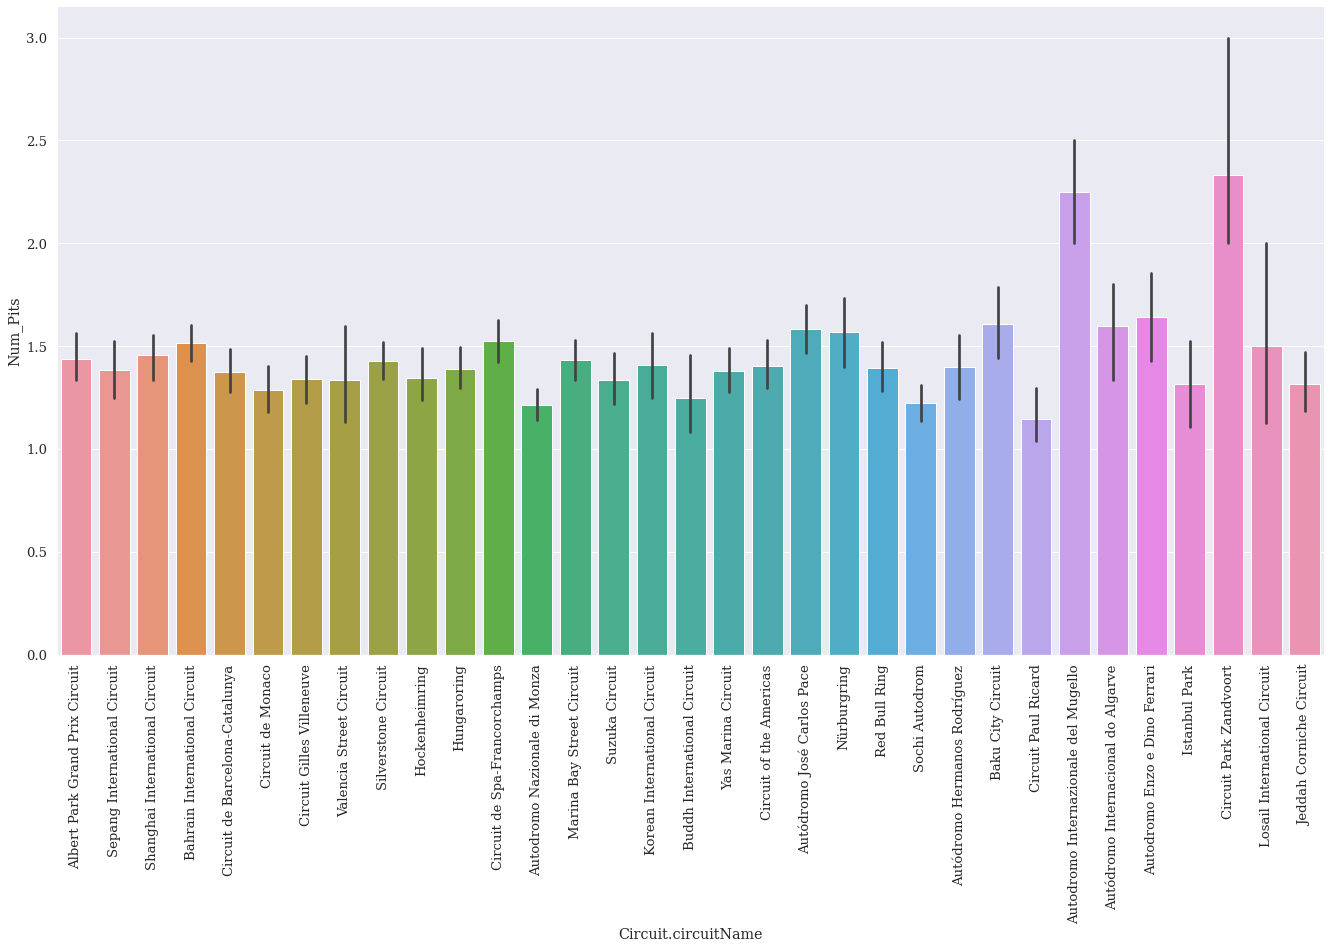

In [202]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
sns.catplot(data=PitsUnified_Finished,x="Circuit.circuitName", y="Num_Pits",kind="bar",height=10,aspect=2)
plt.xticks(rotation=90)
plt.show()

### Average numper of pit stops per year

The number of pit stops on average decreased in 2018. This might have been caused by several causes like changes in the regulations, different circuits in that season, etc.

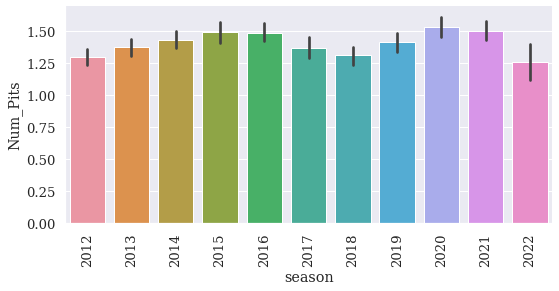

In [203]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
sns.catplot(data=PitsUnified_Finished,x="season", y="Num_Pits",kind="bar",height=4,aspect=2)
plt.xticks(rotation=90)
plt.show()

### Average number of laps between pit stops per circuit

We can see that contrary to what it was believed, the number of laps on average per pit stop have increased and decreased depending on each circuit.

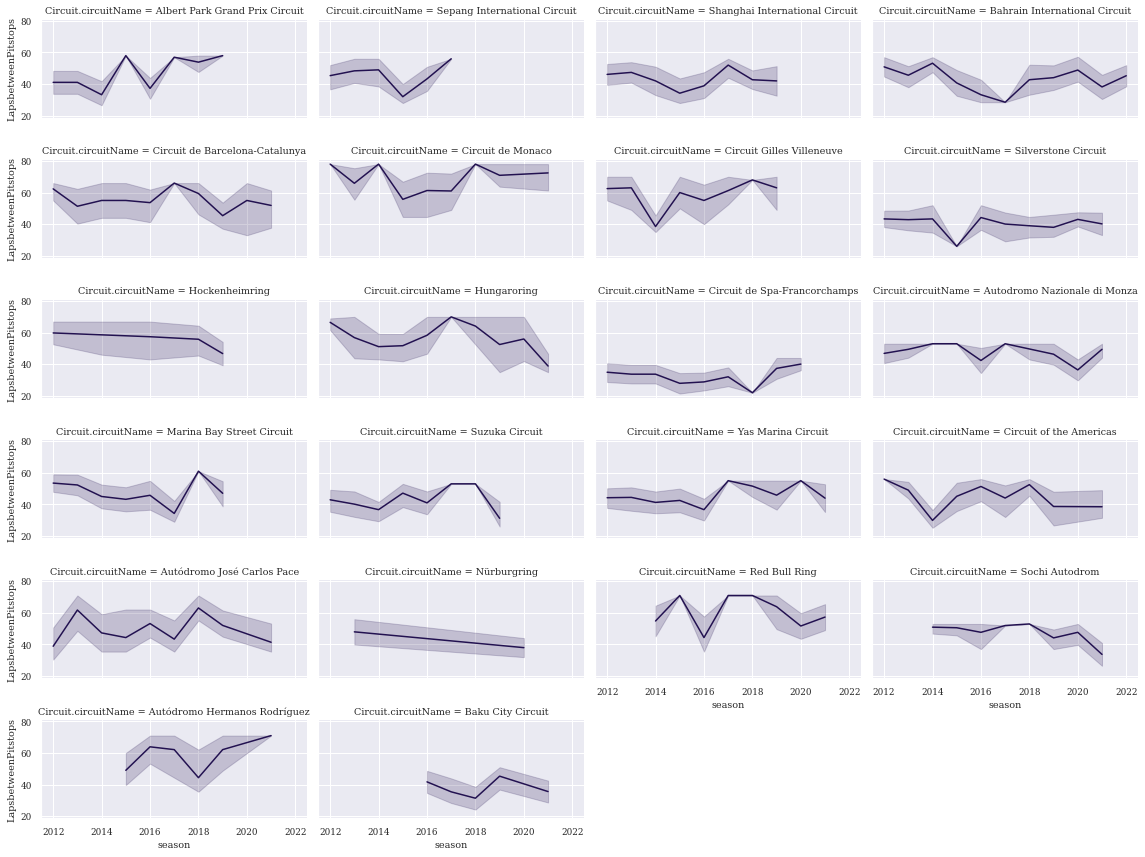

In [204]:
#Selecting specific circuits where at least two seasons a race has been helds=
SelectedCircuits=['albert_park', 'sepang', 'shanghai', 'bahrain', 'catalunya',
       'monaco', 'villeneuve', 'silverstone',
       'hockenheimring', 'hungaroring', 'spa', 'monza', 'marina_bay',
       'suzuka', 'yas_marina', 'americas',
       'interlagos', 'nurburgring', 'red_bull_ring', 'sochi', 'rodriguez',
       'BAK']

PitsUnified_Finished_Selected=PitsUnified_Finished[PitsUnified_Finished["Circuit.circuitId"].isin(SelectedCircuits) == True]

sns.set_theme(style="darkgrid", palette="magma",font_scale=0.8,font="serif")
sns.relplot(data=PitsUnified_Finished_Selected,x="season", y="LapsbetweenPitstops",col="Circuit.circuitName",col_wrap=4,kind="line",height=2,aspect=2)

### Average number of laps between pit stops

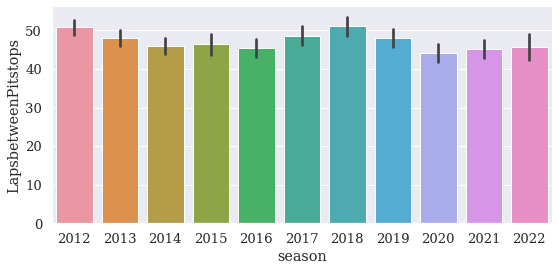

In [205]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
sns.catplot(data=PitsUnified_Finished,x="season", y="LapsbetweenPitstops",kind="bar",height=4,aspect=2)

### Encoding the categorical features

In [206]:
from sklearn.preprocessing import LabelEncoder

#Features to encode:
to_encode=['Season-Round-Driver', 'driverId', 'Circuit.circuitId','Circuit.Location.country', 'Constructor.constructorId']

for n in to_encode:
    encoder = LabelEncoder()
    encoder.fit(PitsUnified_Finished[n])
    nameencoded=n+"_enc"
    encoders=encoder.transform(PitsUnified_Finished[n])
    PitsUnified_Finished[nameencoded]=encoders

PitsUnified_Finished=PitsUnified_Finished.reset_index() #reset index of added features, if this is not done, there is an error later
PitsUnified_Finished=PitsUnified_Finished.drop(columns=["index"])

### Relationship between features

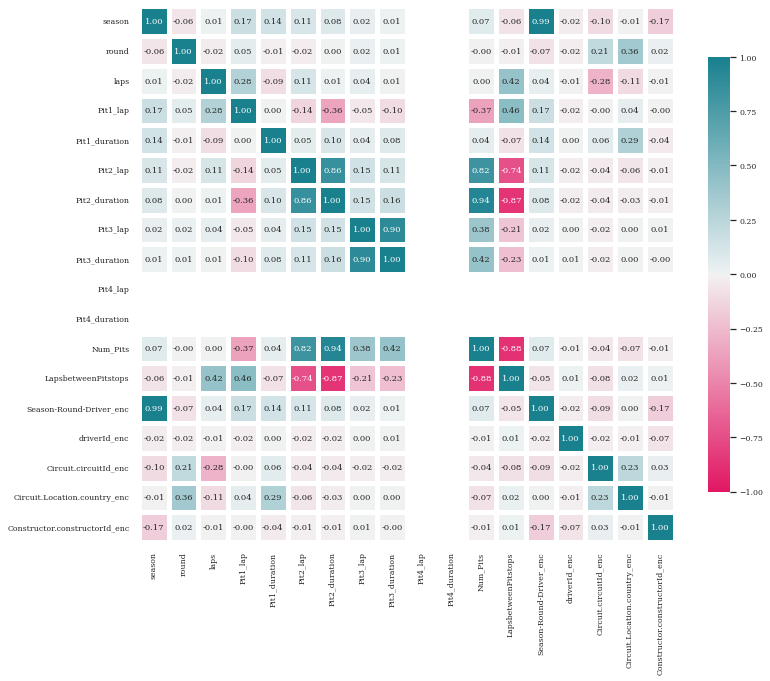

In [207]:
#Relationship between all the variables

#Calculating correlation: Heatmap
sns.set_theme(style="whitegrid", palette="magma",font_scale=0.7,font="serif")
fig, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(0, 210, 95, 49, as_cmap=True)
sns.heatmap(PitsUnified_Finished.corr(), annot=True, fmt=".2f", 
           linewidths=5,cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)
plt.show()

### Before making predictions...

In [208]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score #measures used to evaluate the models
from sklearn.metrics import confusion_matrix, classification_report #confusion matrix to evaluate results

from sklearn.model_selection import GridSearchCV #Hyperparameter optimization
from sklearn.model_selection import KFold #set kfold configuration
from sklearn.model_selection import cross_val_score #cross validation
from sklearn.metrics import make_scorer #set scores desired to train models
from sklearn.metrics import mean_squared_error

#Set scorers
f1_scorer=make_scorer(f1_score)
accuracy_scorer=make_scorer(accuracy_score)

### Function to test and evaluate the algorithms
def testing_the_classifier(ticks_, thesize=(5,3)):
    Train=pd.DataFrame()
    Train["Predicted"]=y_train_predicted
    Train["Real"]=y_train.tolist()

    Test=pd.DataFrame()
    Test["Predicted"]=y_test_predicted
    Test["Real"]=y_test.tolist()

    #Generate the confusion matrixes

    cf_matrixtrain = confusion_matrix(Train["Real"], Train["Predicted"])
    cf_matrixtest = confusion_matrix(Test["Real"], Test["Predicted"])

    print("\n Training Data:")
    sns.set_theme(style="whitegrid", palette="BuPu",font_scale=1,font="serif")
    plt.figure(figsize=thesize)
    ax = sns.heatmap(cf_matrixtrain, annot=True,cmap="BuPu",fmt='d')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(ticks_)
    ax.yaxis.set_ticklabels(ticks_)
    plt.show()

    print(classification_report(y_train, y_train_predicted))

    print("F1 Score:",f1_score(y_train, y_train_predicted,average="weighted"))
    print("Recall:",recall_score(y_train,y_train_predicted,average="weighted"))
    print("Precision:",precision_score(y_train,y_train_predicted,average="weighted"))

    

    print("\n Testing Data:")
    sns.set_theme(style="whitegrid", palette="BuPu",font_scale=1,font="serif")
    plt.figure(figsize=thesize)
    ax = sns.heatmap(cf_matrixtest, annot=True,cmap="BuPu",fmt='d')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(ticks_)
    ax.yaxis.set_ticklabels(ticks_)
    plt.show()

    print(classification_report(y_test, y_test_predicted))

    print("F1 Score:",f1_score(y_test, y_test_predicted,average="weighted"))
    print("Recall:",recall_score(y_test, y_test_predicted,average="weighted"))
    print("Precision:",precision_score(y_test, y_test_predicted,average="weighted"))


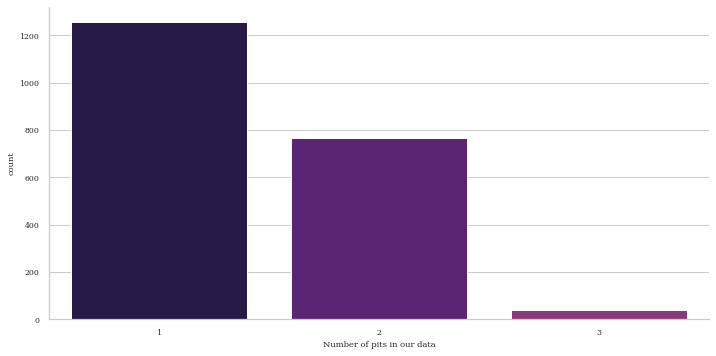

In [209]:
#Bar plot: class distribution
g=sns.catplot(x="Num_Pits",data=PitsUnified_Finished,kind="count",height=5,aspect=2)
g.set(xlabel="Number of pits in our data")
plt.show()

#There exists a class imbalance

In [210]:
len(PitsUnified_Finished[PitsUnified_Finished["Num_Pits"]==3]) #number of drivers-races with 3 pitstops

41

## 1st: Random Forest Classifier to predict the feature "Num_Pits"

In [211]:
#PitsUnified_Finished.columns

Selected=['season','round','laps', 'driverId_enc',
       'Circuit.circuitId_enc', 'Circuit.Location.country_enc',
       'Constructor.constructorId_enc']


In [212]:
#Divide data into training and testing - stratified
from sklearn.model_selection import train_test_split #separte train and test data

X_train, X_test, y_train, y_test = train_test_split(PitsUnified_Finished[Selected], PitsUnified_Finished["Num_Pits"], test_size=0.20,stratify=PitsUnified_Finished["Num_Pits"],random_state=selectednumber)


In [213]:
len(X_train)

1652

In [214]:
# from sklearn.ensemble import RandomForestClassifier

# #Cross Validation using Grid Search
# RF=RandomForestClassifier(random_state=selectednumber)
# tuned_parameters = {
#     #'bootstrap': [False,True], #it always shows a better result with bootstrapping in this case
#     'max_depth': [10,15,20],
#     'min_samples_leaf': [2, 3], #in tests before only 2 and 3 were selected
#     'min_samples_split': [2, 4, 6, 8, 10],
#     'criterion': ["gini","entropy"],
#     "max_features":["auto",None],
#     "n_estimators":[100,200]}

# for x in [5,7,9]:
#     clf2 = GridSearchCV(RF, tuned_parameters, cv=KFold(n_splits=x), scoring=accuracy_scorer)
#     clf2.fit(X_train, y_train)
#     print("Folds: ",x,"- Accuracy: ",clf2.best_score_," ",clf2.best_params_)

In [215]:
from sklearn.ensemble import RandomForestClassifier
RF1=RandomForestClassifier(random_state=selectednumber,n_estimators=100,max_depth=20,min_samples_split=2,criterion="gini",max_features="auto",min_samples_leaf=2)
RF1.fit(X_train, y_train)
y_train_predicted=RF1.predict(X_train)
y_test_predicted=RF1.predict(X_test)

mse_train = mean_squared_error(y_train,y_train_predicted)
mse_test = mean_squared_error(y_test,y_test_predicted)
print(mse_train,"-",mse_test)

0.11198547215496368 - 0.41646489104116224


## 1st: Results


 Training Data:


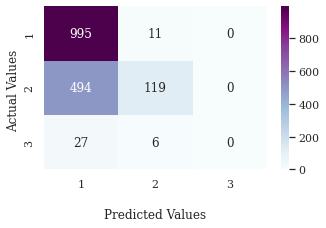

              precision    recall  f1-score   support

           1       0.66      0.99      0.79      1006
           2       0.88      0.19      0.32       613
           3       0.00      0.00      0.00        33

    accuracy                           0.67      1652
   macro avg       0.51      0.39      0.37      1652
weighted avg       0.72      0.67      0.60      1652

F1 Score: 0.5984114340655663
Recall: 0.6743341404358354
Precision: 0.7243616516639301

 Testing Data:


C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

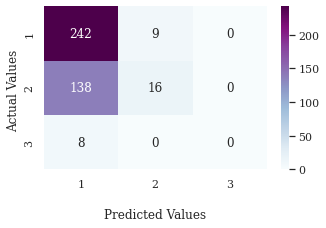

              precision    recall  f1-score   support

           1       0.62      0.96      0.76       251
           2       0.64      0.10      0.18       154
           3       0.00      0.00      0.00         8

    accuracy                           0.62       413
   macro avg       0.42      0.36      0.31       413
weighted avg       0.62      0.62      0.53       413

F1 Score: 0.5269891820914651
Recall: 0.6246973365617433
Precision: 0.6177035021592072


C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [237]:
testing_the_classifier(["1","2","3"])

## 2nd: Random Forest Classifier to predict the feature Lap of pit stops (if any)

First, predicting the lap in which the first pit stop is done

Secondly, predicting the lap in which the second pit stop is done (0 is also an option with 0 pit stops)

Thirdly, predicting the lap in which the third pit stop is done (0 is also an option with 0 pit stops)

In [217]:
#Function to evaluate the models
from sklearn import metrics

def evaluatelapspitstops(y_train,y_train_predicted,y_test,y_test_predicted):
    y_true = y_train 
    y_pred = y_train_predicted 

    print("\n Training Scores:")
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
    print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
    print('Max Error:', metrics.max_error(y_true, y_pred))
    print('R^2:', metrics.r2_score(y_true, y_pred))

    print("F1 Score:",f1_score(y_true, y_pred,average="weighted"))
    print("Recall:",recall_score(y_true,y_pred,average="weighted"))
    print("Precision:",precision_score(y_true,y_pred,average="weighted"))

    y_true = y_test 
    y_pred = y_test_predicted 
    
    print("\n Testing Scores:")
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
    print('Max Error:', metrics.max_error(y_true, y_pred))
    print('R^2:', metrics.r2_score(y_true, y_pred))

    print("F1 Score:",f1_score(y_true, y_pred,average="weighted"))
    print("Recall:",recall_score(y_true,y_pred,average="weighted"))
    print("Precision:",precision_score(y_true,y_pred,average="weighted"))


In [218]:
#PitsUnified_Finished.columns

Selected=['season','round','laps', 'driverId_enc',
       'Circuit.circuitId_enc', 'Circuit.Location.country_enc',
       'Constructor.constructorId_enc','Pit1_lap','Pit2_lap','Pit3_lap','Pit4_lap',"Num_Pits"]

#The 3 features including the Pit laps will be taken out later

#randomseed

In [219]:
#Divide data into training and testing - stratified
from sklearn.model_selection import train_test_split #separte train and test data

X_train, X_test, y_train, y_test = train_test_split(PitsUnified_Finished[Selected], PitsUnified_Finished['Pit1_lap'], test_size=0.20,stratify=PitsUnified_Finished["Num_Pits"],random_state=selectednumber)
#X_train, X_test, y_train, y_test = train_test_split(PitsUnified_Finished[Selected], PitsUnified_Finished['Pit1_lap'], test_size=0.20,random_state=selectednumber)


In [220]:
PitInfotrain=X_train[['Pit1_lap','Pit2_lap','Pit3_lap','Pit4_lap',"Num_Pits"]] #we needed them to have this info in the correct order for later
X_train=X_train.drop(columns=['Pit1_lap','Pit2_lap','Pit3_lap','Pit4_lap',"Num_Pits"]) #the 3 features are dropped from the training set

PitInfotest=X_test[['Pit1_lap','Pit2_lap','Pit3_lap','Pit4_lap',"Num_Pits"]] #we needed them to have this info in the correct order for later
X_test=X_test.drop(columns=['Pit1_lap','Pit2_lap','Pit3_lap','Pit4_lap',"Num_Pits"]) #the 3 features are dropped from the training set


#### Starting to predict the lap of pit stop 1...

In [221]:
# #Cross Validation using Grid Search

# RF=RandomForestClassifier(random_state=selectednumber)
# tuned_parameters = {
#     #'bootstrap': [False,True], #it always shows a better result with bootstrapping in this case
#     'max_depth': [10,20,30,40],
#     'min_samples_leaf': [2,3,4,5,6,7,8,9],
#     'min_samples_split': [2,6,10,14,18,22],
#     'criterion': ["gini","entropy"],
#     "max_features":["auto",None],
#     "n_estimators":[100,200]}

# for x in [5,7,9]:
#     clf2 = GridSearchCV(RF, tuned_parameters, cv=KFold(n_splits=x), scoring=accuracy_scorer)
#     clf2.fit(X_train, y_train)
#     print("Folds: ",x,"- Accuracy: ",clf2.best_score_," ",clf2.best_params_)

In [222]:
RF2=RandomForestClassifier(random_state=selectednumber,criterion="gini",max_depth=10,max_features="auto",min_samples_leaf=2,min_samples_split=6,n_estimators=100)

RF2.fit(X_train, y_train)
y_train_predicted=RF2.predict(X_train)
y_test_predicted=RF2.predict(X_test)

evaluatelapspitstops(y_train,y_train_predicted,y_test,y_test_predicted)



 Training Scores:
Mean Absolute Error (MAE): 2.883777239709443
Mean Squared Error (MSE): 42.22760290556901
Explained Variance Score: 0.552381500547051
Max Error: 39
R^2: 0.5401329707757284
F1 Score: 0.6036798953932587
Recall: 0.6101694915254238
Precision: 0.6362781495580322

 Testing Scores:
Mean Absolute Error (MAE): 5.329297820823244
Mean Squared Error (MSE): 77.49394673123487
Max Error: 40
R^2: 0.17203969629828764
F1 Score: 0.1757817011387965
Recall: 0.1864406779661017
Precision: 0.18197864457661198


C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [223]:
print("Classification Report:")
print(classification_report(y_train, y_train_predicted))

Classification Report:
              precision    recall  f1-score   support

           1       0.65      0.71      0.68        79
           2       0.97      0.80      0.88        44
           3       0.75      0.67      0.71         9
           4       0.74      0.77      0.76        22
           5       0.73      0.40      0.52        20
           6       0.65      0.44      0.52        25
           7       0.65      0.73      0.69        48
           8       0.67      0.45      0.54        40
           9       0.58      0.70      0.64        60
          10       0.54      0.72      0.62        87
          11       0.66      0.69      0.68        78
          12       0.62      0.76      0.68        94
          13       0.50      0.71      0.59       101
          14       0.44      0.71      0.54        82
          15       0.71      0.62      0.66        73
          16       0.71      0.63      0.67        70
          17       0.60      0.63      0.62        46
    

C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [224]:
print("Classification Report:")
print(classification_report(y_test, y_test_predicted))

Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.65      0.57        20
           2       1.00      0.55      0.71        11
           3       0.33      0.33      0.33         3
           4       0.57      0.80      0.67         5
           5       0.50      0.43      0.46         7
           6       0.00      0.00      0.00         5
           7       0.23      0.23      0.23        13
           8       0.11      0.08      0.09        13
           9       0.37      0.35      0.36        20
          10       0.28      0.43      0.34        21
          11       0.00      0.00      0.00        18
          12       0.09      0.17      0.12        18
          13       0.20      0.27      0.23        33
          14       0.08      0.14      0.10        22
          15       0.09      0.07      0.08        15
          16       0.07      0.08      0.07        13
          17       0.11      0.06      0.08        16
    

C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [225]:
#Including the info of the laps PREDICTED for the fist pitstop into the independent features in the training and testing set
X_train["Pit1_lap_predicted"]=y_train_predicted
X_test["Pit1_lap_predicted"]=y_test_predicted

y_train=PitInfotrain['Pit2_lap'].copy(deep=True) #changing the dependent feauture to pitstops2
y_test=PitInfotest['Pit2_lap'].copy(deep=True) #changing the dependent feauture to pitstops2


#### Starting to predict the lap of pit stop 2...

In [226]:
# #Cross Validation using Grid Search

# RF=RandomForestClassifier(random_state=selectednumber)

# #This sections was runned severl times to set the limits of the analysis for the grid search

# tuned_parameters = {
#     #'bootstrap': [False,True], #it always shows a better result with bootstrapping in this case
#     'max_depth': [None,5,10,15],
#     'min_samples_leaf': [2,3,4],
#     'min_samples_split': [6,7,8,9,10],
#     'criterion': ["gini","entropy"],
#     #"max_features":[None], #it always works better with no max features
#     "n_estimators":[150]}

# for x in [5,7,9]:
#     clf2 = GridSearchCV(RF, tuned_parameters, cv=KFold(n_splits=x), scoring=accuracy_scorer)
#     clf2.fit(X_train, y_train)
#     print("Folds: ",x,"- Accuracy: ",clf2.best_score_," ",clf2.best_params_)

In [227]:
RF3=RandomForestClassifier(n_estimators=100,random_state=selectednumber,criterion="entropy",max_depth=None,min_samples_leaf=3,min_samples_split=7)

RF3.fit(X_train, y_train)
y_train_predicted=RF3.predict(X_train)
y_test_predicted=RF3.predict(X_test)

evaluatelapspitstops(y_train,y_train_predicted,y_test,y_test_predicted)


 Training Scores:
Mean Absolute Error (MAE): 10.194915254237289
Mean Squared Error (MSE): 367.319612590799
Explained Variance Score: 0.051386211088711
Max Error: 70.0
R^2: -0.2962230688255958
F1 Score: 0.5603635425883053
Recall: 0.6658595641646489
Precision: 0.577081594289157

 Testing Scores:
Mean Absolute Error (MAE): 11.537530266343826
Mean Squared Error (MSE): 407.63438256658594
Max Error: 63.0
R^2: -0.48627077520211337
F1 Score: 0.4911973944201206
Recall: 0.6198547215496368
Precision: 0.408403375328814


C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [228]:
print("Classification Report:")
print(classification_report(y_train, y_train_predicted))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.99      0.79      1006
         2.0       0.91      0.77      0.83        13
         3.0       0.82      0.93      0.87        15
         4.0       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         1
         7.0       0.00      0.00      0.00         3
         8.0       0.81      0.93      0.87        14
         9.0       0.89      0.73      0.80        11
        11.0       0.00      0.00      0.00         5
        12.0       0.00      0.00      0.00         1
        13.0       0.67      0.40      0.50        10
        14.0       0.00      0.00      0.00         4
        15.0       0.00      0.00      0.00         5
        16.0       0.00      0.00      0.00         7
        17.0       1.00      0.30      0.46        10
        18.0       0.70      0.41      0.52        17
        19.0       0.00      0.00      0.00        12
    

C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [229]:
print("Classification Report:")
print(classification_report(y_test, y_test_predicted))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.96      0.76       251
         2.0       0.71      0.83      0.77         6
         3.0       0.67      1.00      0.80         2
         4.0       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         1
         7.0       0.00      0.00      0.00         1
         8.0       1.00      1.00      1.00         3
         9.0       0.00      0.00      0.00         0
        11.0       0.00      0.00      0.00         1
        13.0       0.50      1.00      0.67         2
        15.0       0.00      0.00      0.00         2
        17.0       0.00      0.00      0.00         1
        18.0       0.50      0.50      0.50         2
        19.0       0.00      0.00      0.00         5
        20.0       0.00      0.00      0.00         5
        21.0       0.00      0.00      0.00         7
        22.0       0.00      0.00      0.00         1
    

C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [230]:
#Including the info of the laps PREDICTED for the second pitstop into the independent features in the training and testing set
X_train["Pit2_lap_predicted"]=y_train_predicted
X_test["Pit2_lap_predicted"]=y_test_predicted

y_train=PitInfotrain['Pit3_lap'].copy(deep=True) #changing the dependent feauture to pitstops3
y_test=PitInfotest['Pit3_lap'].copy(deep=True) #changing the dependent feauture to pitstops3


#### Starting to predict the lap of pit stop 3...

In [231]:
# #Cross Validation using Grid Search

# RF=RandomForestClassifier(random_state=selectednumber)

# #This sections was runned severl times to set the limits of the analysis for the grid search

# tuned_parameters = {
#     #'bootstrap': [False,True], #it always shows a better result with bootstrapping in this case
#     'max_depth': [None,5,10],
#     'min_samples_leaf': [6,7,8,9],
#     'min_samples_split': [2,3,4],
#     #'criterion': ["gini","entropy"], #gini always performs better
#     #"max_features":[None], #it always works better with no max features
#     "n_estimators":[150]}

# for x in [5,7,9]:
#     clf2 = GridSearchCV(RF, tuned_parameters, cv=KFold(n_splits=x), scoring=accuracy_scorer)
#     clf2.fit(X_train, y_train)
#     print("Folds: ",x,"- Accuracy: ",clf2.best_score_," ",clf2.best_params_)

In [232]:
RF4=RandomForestClassifier(n_estimators=100,random_state=selectednumber,criterion="gini",max_depth=None,min_samples_leaf=8,min_samples_split=2)

RF4.fit(X_train, y_train)
y_train_predicted=RF4.predict(X_train)
y_test_predicted=RF4.predict(X_test)

ticks=PitsUnified_Finished["Pit3_lap"].unique()

evaluatelapspitstops(y_train,y_train_predicted,y_test,y_test_predicted)


 Training Scores:
Mean Absolute Error (MAE): 0.7239709443099274
Mean Squared Error (MSE): 32.27845036319613
Explained Variance Score: 0.0
Max Error: 72.0
R^2: -0.01650591122873113
F1 Score: 0.970137084052903
Recall: 0.9800242130750605
Precision: 0.9604474582133916

 Testing Scores:
Mean Absolute Error (MAE): 0.6513317191283293
Mean Squared Error (MSE): 26.53995157384988
Max Error: 51.0
R^2: -0.01624435518703171
F1 Score: 0.9710390310033922
Recall: 0.9806295399515739
Precision: 0.9616342946256354


C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Now that we have the predicted laps for each pit stop, we translate this variables into one that says how many pit stops we have.

In [233]:
#Including pits4 information
X_train["Pit4_lap"]=PitInfotrain['Pit4_lap'] 
X_test["Pit4_lap"]=PitInfotest['Pit4_lap'] 

#Including the info of the laps PREDICTED for the second pitstop into the independent features in the training and testing set
X_train["Pit3_lap_predicted"]=y_train_predicted
X_test["Pit3_lap_predicted"]=y_test_predicted

#Adding the total number of pits per driver and per race p1
conditionsX_train = [
    (X_train['Pit4_lap'] > 0),
    (X_train['Pit4_lap'] == 0) & (X_train['Pit3_lap_predicted'] > 0),
    (X_train['Pit4_lap'] == 0) & (X_train['Pit3_lap_predicted'] == 0) & (X_train['Pit2_lap_predicted'] > 0),
    (X_train['Pit4_lap'] == 0) & (X_train['Pit3_lap_predicted'] == 0) & (X_train['Pit2_lap_predicted'] == 0) & (X_train['Pit1_lap_predicted'] > 0)
]

conditionsX_test = [
    (X_test['Pit4_lap'] > 0),
    (X_test['Pit4_lap'] == 0) & (X_test['Pit3_lap_predicted'] > 0),
    (X_test['Pit4_lap'] == 0) & (X_test['Pit3_lap_predicted'] == 0) & (X_test['Pit2_lap_predicted'] > 0),
    (X_test['Pit4_lap'] == 0) & (X_test['Pit3_lap_predicted'] == 0) & (X_test['Pit2_lap_predicted'] == 0) & (X_test['Pit1_lap_predicted'] > 0)
]

values = [4, 3, 2, 1]

#Adding the total number of pits per driver and per race p2
X_train['Num_Pits_Predicted'] = np.select(conditionsX_train, values)
X_test['Num_Pits_Predicted'] = np.select(conditionsX_test, values)

In [234]:
y_train=PitInfotrain['Num_Pits']
y_test=PitInfotest['Num_Pits']

y_train_predicted=X_train['Num_Pits_Predicted']
y_test_predicted=X_test['Num_Pits_Predicted']


## 2nd: Results


 Training Data:


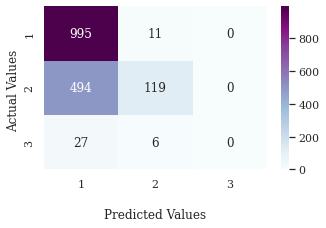

              precision    recall  f1-score   support

           1       0.66      0.99      0.79      1006
           2       0.88      0.19      0.32       613
           3       0.00      0.00      0.00        33

    accuracy                           0.67      1652
   macro avg       0.51      0.39      0.37      1652
weighted avg       0.72      0.67      0.60      1652

F1 Score: 0.5984114340655663
Recall: 0.6743341404358354
Precision: 0.7243616516639301

 Testing Data:


C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

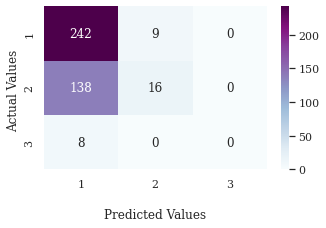

              precision    recall  f1-score   support

           1       0.62      0.96      0.76       251
           2       0.64      0.10      0.18       154
           3       0.00      0.00      0.00         8

    accuracy                           0.62       413
   macro avg       0.42      0.36      0.31       413
weighted avg       0.62      0.62      0.53       413

F1 Score: 0.5269891820914651
Recall: 0.6246973365617433
Precision: 0.6177035021592072


C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [235]:
testing_the_classifier(["1","2","3"])

## 3rd: Multilayer Perceptron

In [236]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import utils

N_EPOCH = 800 
BATCH_SIZE = 30 
VERBOSE = 1
N_CLASSES = PitsUnified_Finished['Num_Pits'].unique().max()  # max number of laps 
OPTIMIZER = SGD(lr=0.05) # Stochastic gradient descent optimiser
N_HIDDEN = 80  # number of hidden units



KeyboardInterrupt: 

In [ ]:
#Divide data into training and testing - stratified

Selected=['season','round','laps', 'driverId_enc',
       'Circuit.circuitId_enc', 'Circuit.Location.country_enc','Constructor.constructorId_enc']

#The 3 features including the Pit laps will be taken out later

X_train, X_test, y_train, y_test = train_test_split(PitsUnified_Finished[Selected], PitsUnified_Finished['Num_Pits'], test_size=0.20,stratify=PitsUnified_Finished["Num_Pits"],random_state=selectednumber)


In [ ]:
# convert class vectors to binary class matrices
y_train = utils.to_categorical(y_train, N_CLASSES+1)

y_test = utils.to_categorical(y_test, N_CLASSES+1)


In [ ]:
#num of parameters is (#independtent+error)*#outputs
# import the dropout layer type
from tensorflow.keras.layers import Dropout

# # Probability of weights dropout
# P_DROPOUT = 0.2

model = Sequential()

#1st hidden layer:
model.add(Dense(N_HIDDEN, input_shape=(X_train.shape[1],))) #imput shape is the number of independent features
model.add(Activation('relu'))
#model.add(Dropout(P_DROPOUT))

#2nd hidden layer
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))
#model.add(Dropout(P_DROPOUT))

#Outpit layer
model.add(Dense(N_CLASSES+1))
model.add(Activation('softmax'))

# model compilation
model.summary()

# model compilation
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                640       
                                                                 
 activation (Activation)     (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 activation_1 (Activation)   (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 324       
                                                                 
 activation_2 (Activation)   (None, 4)                 0         
                                                                 
Total params: 7,444
Trainable params: 7,444
Non-trainabl

In [ ]:
#train the network
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=0.2)

Epoch 1/800
45/45 [==============================] - 0s 3ms/step - loss: 627850.3125 - accuracy: 0.5920 - val_loss: 1.0569 - val_accuracy: 0.5952
Epoch 2/800
45/45 [==============================] - 0s 1ms/step - loss: 0.9871 - accuracy: 0.6117 - val_loss: 0.9207 - val_accuracy: 0.5952
Epoch 3/800
45/45 [==============================] - 0s 1ms/step - loss: 0.8979 - accuracy: 0.6117 - val_loss: 0.8575 - val_accuracy: 0.5952
Epoch 4/800
45/45 [==============================] - 0s 1ms/step - loss: 0.8552 - accuracy: 0.6117 - val_loss: 0.8238 - val_accuracy: 0.5952
Epoch 5/800
45/45 [==============================] - 0s 1ms/step - loss: 0.8305 - accuracy: 0.6117 - val_loss: 0.7989 - val_accuracy: 0.5952
Epoch 6/800
45/45 [==============================] - 0s 1ms/step - loss: 0.8151 - accuracy: 0.6117 - val_loss: 0.7850 - val_accuracy: 0.5952
Epoch 7/800
45/45 [==============================] - 0s 997us/step - loss: 0.8043 - accuracy: 0.6117 - val_loss: 0.7745 - val_accuracy: 0.5952
Epoch 

## 3rd: Results

In [ ]:
print("Final Scores:")
scoretr = model.evaluate(X_train, y_train)
scorete = model.evaluate(X_test, y_test)

print("\nTraining score/loss:", scoretr[0])
print("Training accuracy:", scoretr[1])
print("\nTest score/loss:", scorete[0])
print("Test accuracy:", scorete[1])



Final Scores:
13/13 [==============================] - 0s 831us/step - loss: 0.7470 - accuracy: 0.6102

Training score/loss: 0.7496907114982605
Training accuracy: 0.6083534955978394

Test score/loss: 0.747005045413971
Test accuracy: 0.6101694703102112


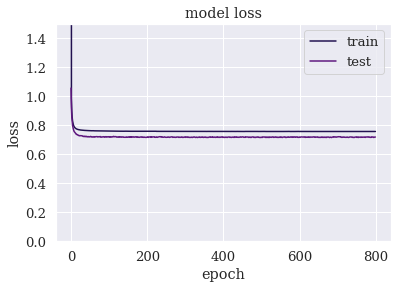

In [ ]:
# summarize history for loss
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
fig, ax = plt.subplots()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_ylim(0, 1.5)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
ax.legend(['train', 'test'], loc='upper right')
plt.show()

# Conclusion... for now...

In the 3 attempts we had, the top percentage of accuracy we got was around the 60%. It is sad to say that to be able to calculate the number of pit stops per race for each driver, we need more features available such as the tire compound, various metrics of the performance of the cars, the weather conditions, etc. Also, factors like safety cars and luck can also influence the number of pit stops and in which lap they were performed. 

In the future, when I find more data available, I would love to try this exercise all over again. 